<font size="30">---------------</font>
<font size="30">Data processing</font>
<font size="30">---------------</font>

<font size="30">1.0 Prepare data</font>

In [ ]:
from pymongo import MongoClient

try: 
    client = MongoClient()
    print("Connected successfully!!!") 
except:
    print("Could not connect to MongoDB") 

db = client.job_advert_db #select database
collection = db.job_advert #select collection to insert

In [ ]:
job_advert_collection = collection.find({})
print("Amount of data collected:" , job_advert_collection.count())

job_adverts_title = []
job_adverts_desc = []

for ja in job_advert_collection:
    job_adverts_title.append(ja['title'])
    job_adverts_desc.append(ja['desc'])

In [ ]:
print(len(job_adverts_title))
print(len(job_adverts_desc))

<font size="30">2.0 Data Preprocessing</font>

In [ ]:
import re, string, unicodedata
import nltk
import contractions #expand the contractions "you're -> you are"
import inflect #convert plural to singular nouns
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords #filter english words "is", "this", "there", etc.
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import tqdm
from bson.json_util import dumps
import pandas as pd

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

word_arr = ['experience','year', 'location', 'apply','relevant', 'include',
                'job', 'advert', 'able', 'based', 'key', 'resume', 
                'company', 'meet', 'change', 'eg', 'salary', 'please', 
            'payroll', 'incident', 'related', 'interested', 'us', 
            'singaporecompany', 'ltd', 'via', 'pte', 'create', 'across', 
            'standard', 'employer', 'holiday', 'new', 'participate', 'people', 'also', 'allow', 'always'
           ]

word_arr = stem_words(word_arr)
word_arr = lemmatize_verbs(word_arr)

stopset = set(stopwords.words('english'))
stopset.update(word_arr)

print(stopset)


2.1 Denoise Job Descriptions

In [6]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    processed_text = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        text = strip_html(t)
        text = remove_between_square_brackets(t)
        processed_text.append(text)
        pbar.update(1)
    pbar.close()
    return processed_text

In [7]:
job_adverts_desc = denoise_text(job_adverts_desc)

100%|████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 5085.37it/s]


2.2 Replace contractions in string

In [8]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    text_arr = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        t = contractions.fix(t)
        text_arr.append(t)
        pbar.update(1)
    pbar.close()
    return text_arr

In [9]:
job_adverts_desc = replace_contractions(job_adverts_desc)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:54<00:00, 88.05it/s]


2.3 Tokenization

In [10]:
temp_arr = []
pbar = tqdm.tqdm(total=len(job_adverts_desc))
for ja in job_adverts_desc:
    temp_arr.append(nltk.word_tokenize(ja))
    pbar.update(1)
job_adverts_desc = temp_arr
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:19<00:00, 249.67it/s]


2.4 Normalization ((1) stemming, (2) lemmatization, and (3) everything else)

In [9]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopset:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_without_stem(words):
    pbar = tqdm.tqdm(total=len(words))
    word_arr = []
    for word in words:
        word = remove_non_ascii(word)
        word = to_lowercase(word)
        word = remove_punctuation(word)
        word = replace_numbers(word)
        word = remove_stopwords(word)
        word_arr.append(word)
        pbar.update(1)
    pbar.close()
    return word_arr

def normalize_stem(words):
    pbar = tqdm.tqdm(total=len(words))
    word_arr = []
    for word in words:
        word = remove_non_ascii(word)
        word = to_lowercase(word)
        word = remove_punctuation(word)
        word = replace_numbers(word)
        word = remove_stopwords(word)
        word = stem_words(word)
        word = lemmatize_verbs(word)
        word_arr.append(word)
        pbar.update(1)
    pbar.close()
    return word_arr

In [12]:
job_adverts_desc_nostem = normalize_without_stem(job_adverts_desc)

100%|█████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:08<00:00, 590.49it/s]


In [13]:
job_adverts_desc = normalize_stem(job_adverts_desc)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:56<00:00, 85.90it/s]


2.5 Remove useless words stick with numbers

In [14]:
def remove_number_word(jobadverts):
    import re
    pbar = tqdm.tqdm(total=10)
    for i in range(1,11):
        for desc in jobadverts:
            for i in desc:
                if(re.search(r'\w*\d\w*', i)):
                    desc.remove(str(i))
        pbar.update(1)
    pbar.close()
    return jobadverts

In [15]:
job_adverts_desc = remove_number_word(job_adverts_desc)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.17s/it]


In [16]:
job_adverts_desc_nostem = remove_number_word(job_adverts_desc_nostem)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.29s/it]


In [17]:
def to_arr(jobadverts):
    temp_arr = []

    for words in jobadverts:
        for word in words:
            temp_arr.append(word)
    return temp_arr

In [18]:
job_adverts_desc_arr = to_arr(job_adverts_desc)

In [19]:
job_adverts_desc_nostem_arr = to_arr(job_adverts_desc_nostem)

In [20]:
print(job_adverts_desc_arr[:10])
print(job_adverts_desc_nostem_arr[:10])

['lead', 'loc', 'enterpriseunderstand', 'cur', 'process', 'valu', 'outcomes', 'structure', 'larg', 'amount']
['leading', 'local', 'enterpriseunderstand', 'current', 'processes', 'valuable', 'outcomesable', 'structure', 'large', 'amount']


Run this to backup data variable

In [21]:
import pickle
with open('job_advert_desc_arr_dump', 'wb') as bf:
    pickle.dump(job_adverts_desc_arr, bf)
with open('job_advert_desc_nostem_arr_dump', 'wb') as bf:
    pickle.dump(job_adverts_desc_nostem_arr, bf)

In [22]:
import pickle
with open('job_advert_desc_dump', 'wb') as bf:
    pickle.dump(job_adverts_desc, bf)
with open('job_advert_title_dump', 'wb') as bf:
    pickle.dump(job_adverts_title , bf)

Run this to load data variable

In [6]:
import pickle
job_adverts_desc = []
with open('job_advert_desc_arr_dump', 'rb') as lf:
    job_adverts_desc_arr = pickle.load(lf)
with open('job_advert_desc_nostem_arr_dump', 'rb') as lf:
    job_adverts_desc_nostem_arr = pickle.load(lf)

In [7]:
import pickle
job_adverts_desc = []
with open('job_advert_desc_dump', 'rb') as lf:
    job_adverts_desc = pickle.load(lf)
with open('job_advert_title_dump', 'rb') as lf:
    job_adverts_title = pickle.load(lf)

In [31]:
import pandas as pd

vocab_frame = pd.DataFrame({'words': job_adverts_desc_nostem_arr}, index = job_adverts_desc_arr)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 897568 items in vocab_frame


In [26]:
print(job_adverts_desc_arr[:10])
print(job_adverts_desc_nostem_arr[:10])
print(job_adverts_desc[:2])
print(job_adverts_title[:2])

['lead', 'loc', 'enterpriseunderstand', 'cur', 'process', 'valu', 'outcomes', 'structure', 'larg', 'amount']
['leading', 'local', 'enterpriseunderstand', 'current', 'processes', 'valuable', 'outcomesable', 'structure', 'large', 'amount']
[['lead', 'loc', 'enterpriseunderstand', 'cur', 'process', 'valu', 'outcomes', 'structure', 'larg', 'amount', 'inform', 'within', 'process', 'frameworkjob', 'scopemappingreview', 'ex', 'busy', 'process', 'reimagin', 'improv', 'on', 'maxim', 'custom', 'valu', 'minim', 'wast', 'incorp', 'automationfacilitatelead', 'process', 'workshop', 'involv', 'elicit', 'process', 'requir', 'lia', 'users', 'interpret', 'busy', 'requir', 'digit', 'solutioncr', 'project', 'plan', 'contain', 'project', 'goal', 'mileston', 'resourcesmonit', 'meas', 'provid', 'feedback', 'process', 'performancelia', 'man', 'coordin', 'process', 'improv', 'project', 'activitiesrequir', 'enjoy', 'vary', 'work', 'widerang', 'rol', 'immers', 'vary', 'diff', 'project', 'see', 'big', 'picturewor

<font size="20">3.0 Finding useful keywords  TF-IDF</font>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

def identity_tokenizer(text):
    return text

#max value max_df is 0.80 output same shape, so deduct to 0.50
tf = TfidfVectorizer(max_df=0.8, min_df=0.010, tokenizer=identity_tokenizer, 
                     analyzer='word', stop_words = stopset, sublinear_tf=True, lowercase=False, 
                     use_idf=True)
tfidf_matrix =  tf.fit_transform(job_adverts_desc)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [19]:
print(tfidf_matrix.shape)
print(tf.get_feature_names())

(4827, 1425)
['abap', 'abreast', 'academ', 'acc', 'acceiv', 'accel', 'access', 'accommod', 'accompl', 'accord', 'account', 'achiev', 'acquir', 'acquisit', 'act', 'acum', 'ad', 'adapt', 'addit', 'address', 'adequ', 'adh', 'adhoc', 'adjust', 'admin', 'adob', 'adopt', 'adv', 'advoc', 'affect', 'ag', 'agil', 'agilescr', 'agr', 'agree', 'ai', 'aim', 'ajax', 'alert', 'algorithm', 'align', 'alloc', 'along', 'alongsid', 'altern', 'amaz', 'amazon', 'amb', 'ambigu', 'ambit', 'among', 'analys', 'analyst', 'android', 'angul', 'angulars', 'anoth', 'answ', 'anticip', 'antivir', 'anywh', 'ap', 'apac', 'apach', 'appl', 'apprecy', 'approach', 'appropry', 'approv', 'aptitud', 'ar', 'architect', 'area', 'around', 'arrang', 'art', 'artic', 'ask', 'aspect', 'aspnet', 'ass', 'assess', 'asset', 'assign', 'assist', 'assocy', 'assum', 'attend', 'attitud', 'attract', 'attribut', 'audit', 'audy', 'auth', 'autom', 'autonom', 'avail', 'aw', 'award', 'az', 'b', 'bachel', 'back', 'backend', 'background', 'backlog', 

<font size="20">4.0 Finding Number of Clusters Elbow method</font>

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = [] 
pbar = tqdm.tqdm(total=15)

for i in range(1, 15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
    pbar.update(1)
pbar.close()
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow(k=1,15).png')
plt.show()

#plot the graph with 
#Sum of squared distances of samples to their closest cluster center.#Within-Cluster-Sum-of-Squares
#agaisnt
#num of clusters

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

Note : <br/>
I decide to use K = 10

<font size="20">5.0 K-Means Clustering</font>

In [94]:
from sklearn.cluster import KMeans

num_clusters = 8

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 3min 23s


Run this to backup kmeans model variable

In [134]:
import pickle
with open('km_model(k=8)', 'wb') as bf:
    pickle.dump(km, bf)

Run this to load data variable

In [8]:
import pickle
with open('km_model(k=8)', 'rb') as lf:
    km = pickle.load(lf)

In [9]:
num_clusters = 8
clusters = km.labels_.tolist()

In [10]:
import pandas as pd

job_adverts = { 'title': job_adverts_title, 'desc': job_adverts_desc, 'cluster': clusters }

frame = pd.DataFrame(job_adverts, index = [clusters] , columns = ['title', 'cluster'])

In [11]:
frame['cluster'].value_counts() #number of job_adverts per cluster (clusters from 0 to 7)

7    947
1    771
3    767
0    719
6    708
4    696
2    129
5     90
Name: cluster, dtype: int64

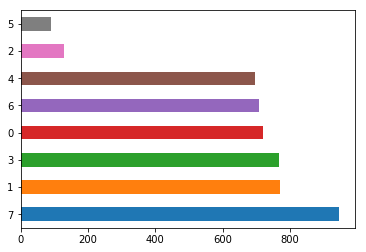

In [14]:

CountStatus = frame['cluster'].value_counts()
CountStatus.plot.barh()


In [49]:
from __future__ import print_function

print("Top terms per cluster:")
print()

terms = tf.get_feature_names()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist()[:10]:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words:

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


 networking, support, hardware, systems, service, troubleshooting, provide, security, administration, configuration, computing, installation, management, windows, operational, software, technical, issues, requirements, infrastructure, work, performance, resolve, monitoring, maintain, maintenance, knowledge, desktop, problem, backup,

Cluster 0 titles:

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 IT Desktop Support | Local MNC | Central, Cloud Architect | Local MNC | Central, Network Architect | Local MNC | Central, IT Customer Service Officer (UBI/UP to $2300/5 days, VMware Engineer, System Engineer (VCAP/ VMware/ up to $5.5K), Presales Network Engineer x 2 (West/ SI/ CCNA/ CCNP/Cisco/ Up to 4.5K), Technical Engineer ( Desktop cum Network support ), IT SUPPORT/HELPDESK OFFICER $2800+BONUS, TROUBLESHOOT DESKTOP/OS @SIMEI/EAST, System / Server Administrator,

Cluster 1 words: management, project, business, teams, processes, ensure, work, solve, requirements, developed, leading, plans, delivery, skills, service, customer, support, communication, responsible, active, operational, stakeholders, analytical, technical, implementing, provide, risk, technology, strong, quality,

Cluster 1 titles: Game Producer | Up to $7000 basic | MNC, SAP Manager and Senior Consultants, Senior Game Producer | Up to $8000 basic | MNC, Head, Infrastructure, Senior Software Developer, Enterprise Accoun

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


 six, guidelines, penetration, adhere, following, assess, matter, contacted,

Cluster 5 titles: Communications Solution Architect (Presales), Regional Marketing Manager, APAC, Sales Engineering Manager, Senior Sales Manager, Pega Developer, SOC Manager, Cybersecurity Specialist, Associate Security Consultant, Security Consultant, Security Lead,

Cluster 6 words: developed, web, design, apicentric, java, javascript, code, frameworks, testing, work, knowledge, technology, spring, software, rest, service, mobile, programming, skills, requirements, net, understanding, databases, strong, css, architecture, systems, good, teams, sql,

Cluster 6 titles: Web / Front End Developer (up to S$7000, Proficient in VUE, Angular, React), PHP Developer / Software Engineer (KL), Web Application Developer (.NET) Central, Kuala Lumpur, Senior .Net Developer, Lead Software Engineer, IT Manager - Java Applications, Software Engineer - PE-JD-640, Artificial Intelligence Bot Engineer Intern, Software Engineer

In [58]:
import random
r = lambda: random.randint(0,255)

cluster_names = [
'networking, support, hardware, systems, service, troubleshooting, security, configuration, computing, installation, windows, operational, technical, issues, monitoring',

'management, project, business, ensure, solve, requirements, plans, delivery, skills, customer, communication, stakeholders, analytical, quality, strong',

'infotech, operational, singaporeemployer, renewal, selection, replication, candidates',

'teams, work, productionize, business, growth, markets, customer, management, learning, data, software, skills, communication, solve',

'testing, requirements, system, design, analytical. software, project, documentations, business, specifications, technical, function, programming, automating, quality, integration',

'security, cyber, tripartite, daryl, nondiscriminatory, consulting, cooperative, threat, min, discriminate',

'developed, web, design, apicentric, java, javascript, code, frameworks, testing, work, net, databases, strong, css, good, sql, teams',

'management, candidates, developed, requirements, management, communication, knowledge, data, project, software, support, business, analytical, sap',
]




cluster_colors = []
num_of_clusters = 8

for num in range(num_of_clusters):
    cluster_colors.append('#%02X%02X%02X' % (r(),r(),r()))

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [102]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, verbose=True)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

Run this to backup kmeans model variable

In [103]:
import pickle
with open('ys', 'wb') as bf:
    pickle.dump(ys, bf)
with open('xs', 'wb') as bf:
    pickle.dump(xs, bf)

Run this to load data variable

In [34]:
import pickle
with open('ys', 'rb') as lf:
    ys = pickle.load(lf)
with open('xs', 'rb') as lf:
    xs = pickle.load(lf)    

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import mpld3

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [62]:
num_of_plots = 2000
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs[:num_of_plots], y=ys[:num_of_plots], 
                       label=clusters[:num_of_plots], 
                       title=job_adverts_title[:num_of_plots]))

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: 200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(20,12)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
#import pickle
with open('mpld3_k8.html', 'wb') as bf:
    pickle.dump(html, bf)

<font size="25">View the exported D3.html !</font>